In [262]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import mean_squared_error
import seaborn as sns
from pyod.models.mad import MAD
import statsmodels.api as sm
from sklearn.linear_model import RANSACRegressor, LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV

In [263]:
#Load the data
X_train =np.load('X_train.npy')
Y_train =np.load('y_train.npy')
X_test =np.load('X_test.npy')

# Divide the data randomly into training and test sets
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=42)

In [264]:
# Create a dataframe for the training data and standardize the features
train_features = ['Air Temperature','Water Temperature','Wind speed','Wind Direction','Illumination']
#Define the colours for the plots associated with each feature
colours = ['deepskyblue', 'aqua', 'mediumvioletred', 'teal', "gold"]
scaler = StandardScaler()
X_val = scaler.fit_transform(X_val)
X_val_df = pd.DataFrame(X_val, columns=train_features)
X_train_norm = pd.DataFrame(scaler.fit_transform(X_train))
X_train_norm = X_train_norm.rename(columns={i:train_features[i] for i in range(5)})
y_train_df = pd.DataFrame(Y_train)
y_train_df.rename(columns={0:'y_train'}, inplace=True)
train_data = X_train_norm.copy()
train_data['Y_train'] = y_train_df.reset_index(drop=True)

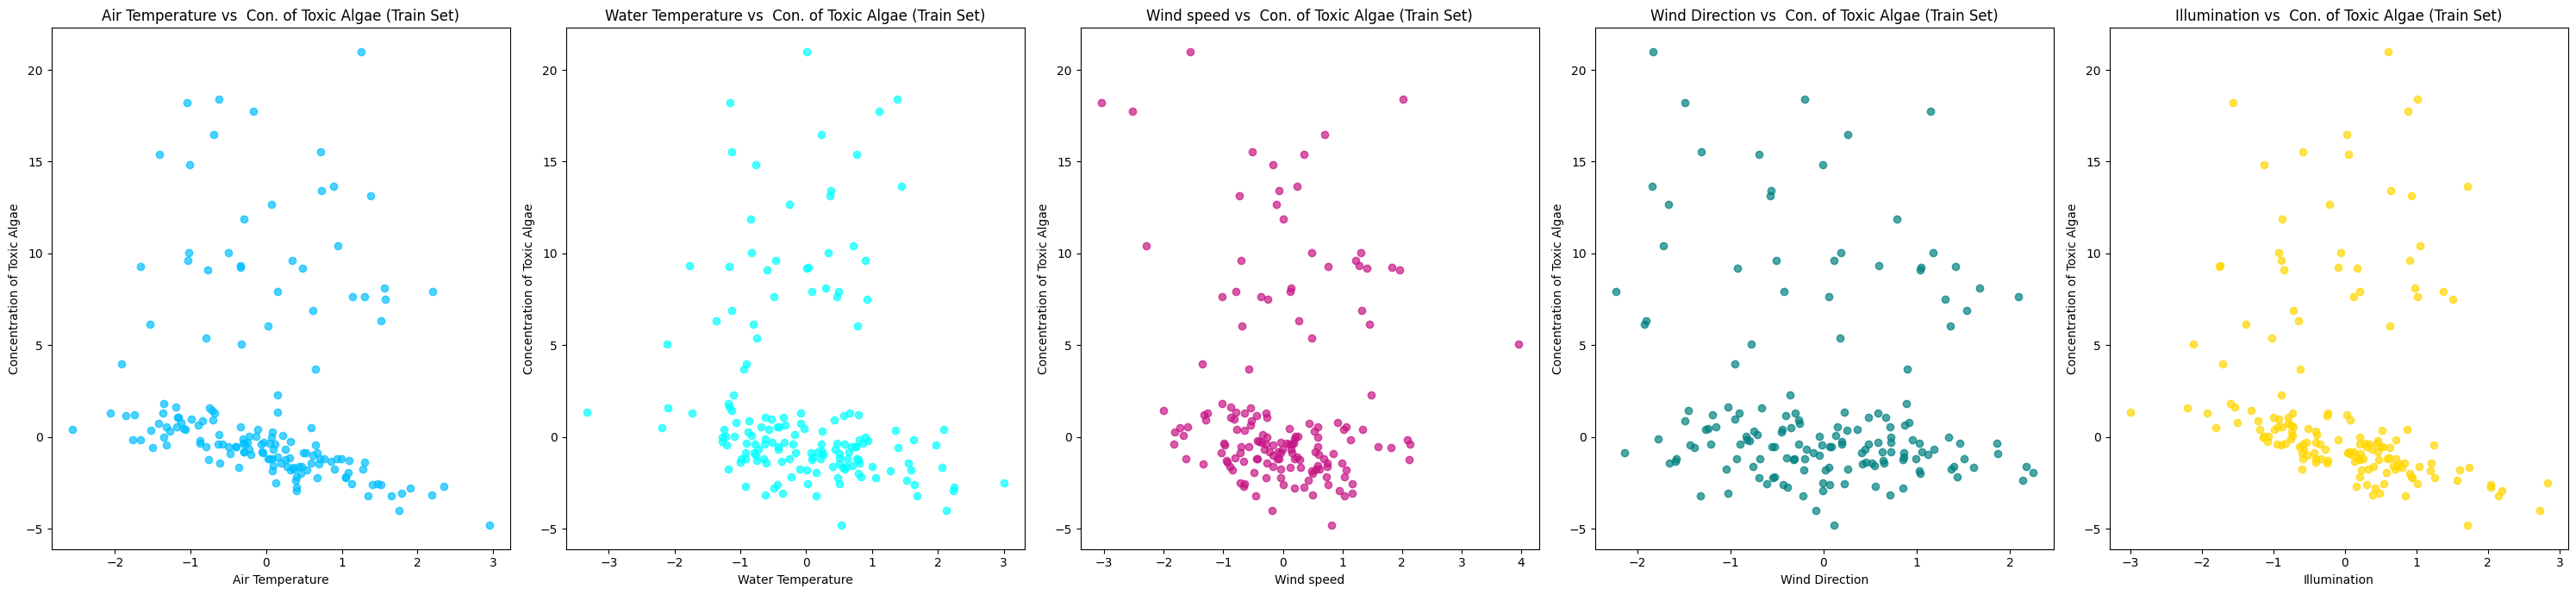

In [265]:
# Plots with training data with outliers to visualize the data
fig, axes = plt.subplots(1, 5, figsize=(30, 7))

for i, feature in enumerate(train_features):
    axes[i].scatter(X_train_norm[feature], Y_train, alpha=0.7, color = colours[i])
    axes[i].set_title(f'{feature} vs  Con. of Toxic Algae (Train Set)')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Concentration of Toxic Algae')

plt.tight_layout() 
plt.show()

**1. Methods to remove outliers for the training set**

1.1 We focused on the output variable, since the human error, the major source of error, affects only the dependent variable. We used IQR method to select 50 outliers.

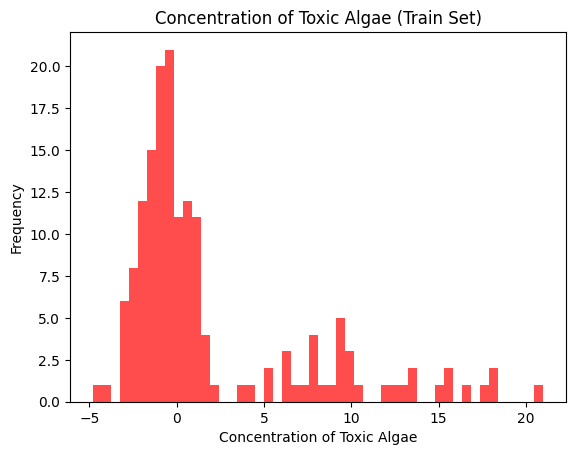

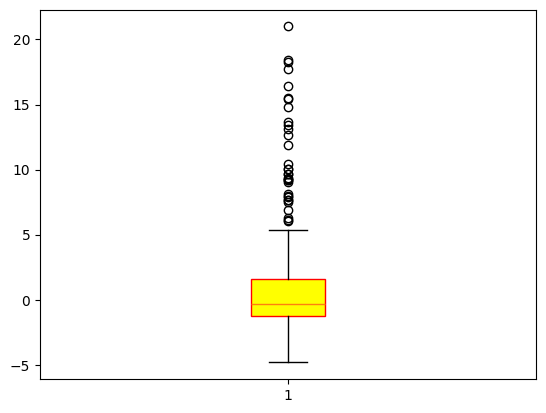

Multiplier: 1.5, Outlier Percentage: 20.62%
Multiplier: 1.49, Outlier Percentage: 20.62%
Multiplier: 1.48, Outlier Percentage: 20.62%
Multiplier: 1.47, Outlier Percentage: 20.62%
Multiplier: 1.46, Outlier Percentage: 20.62%
Multiplier: 1.45, Outlier Percentage: 20.62%
Multiplier: 1.44, Outlier Percentage: 20.62%
Multiplier: 1.43, Outlier Percentage: 20.62%
Multiplier: 1.42, Outlier Percentage: 20.62%
Multiplier: 1.41, Outlier Percentage: 20.62%
Multiplier: 1.4, Outlier Percentage: 20.62%
Multiplier: 1.39, Outlier Percentage: 20.62%
Multiplier: 1.38, Outlier Percentage: 20.62%
Multiplier: 1.3699999999999999, Outlier Percentage: 20.62%
Multiplier: 1.3599999999999999, Outlier Percentage: 20.62%
Multiplier: 1.3499999999999999, Outlier Percentage: 20.62%
Multiplier: 1.3399999999999999, Outlier Percentage: 20.62%
Multiplier: 1.3299999999999998, Outlier Percentage: 20.62%
Multiplier: 1.3199999999999998, Outlier Percentage: 21.25%
Multiplier: 1.3099999999999998, Outlier Percentage: 21.25%
Mult

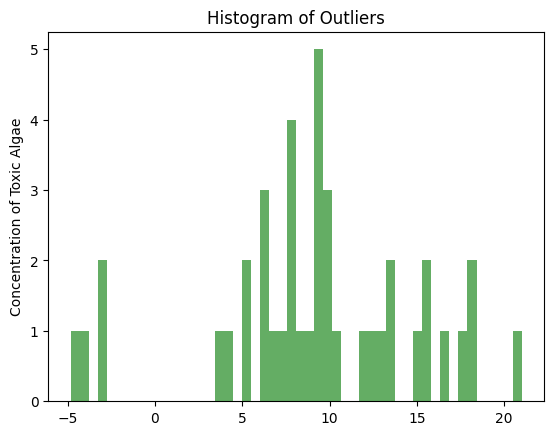

In [266]:
plt.hist(Y_train, bins=50, color='red', alpha=0.7)
plt.title('Concentration of Toxic Algae (Train Set)')
plt.xlabel('Concentration of Toxic Algae')
plt.ylabel('Frequency')
plt.show()

plt.boxplot(Y_train,patch_artist=True,boxprops=dict(facecolor='yellow', color='red'))
plt.show()

def calculate_outliers(multiplier):
    Q1 = train_data['Y_train'].quantile(0.25)
    Q3 = train_data['Y_train'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - multiplier * IQR
    upper_bound = Q3 + multiplier * IQR
    outliers = train_data['Y_train'][(train_data['Y_train'] < lower_bound) | (train_data['Y_train'] > upper_bound)]
    return outliers

target_percentage = 0.25
multiplier = 1.5
step = 0.01

while True:
    outliers = calculate_outliers(multiplier)
    outlier_percentage = len(outliers) / len(train_data['Y_train'])
    print(f"Multiplier: {multiplier}, Outlier Percentage: {outlier_percentage:.2%}")
    
    if outlier_percentage >= target_percentage:
        break
    multiplier -= step

print(f"\nFinal Multiplier: {multiplier}")
print(f"Number of outliers: {len(outliers)}")
print(f"Outlier Percentage: {outlier_percentage:.2%}")

plt.hist(outliers, bins=50, color='forestgreen', alpha=0.7)
plt.title('Histogram of Outliers')
plt.ylabel('Concentration of Toxic Algae')
plt.show()

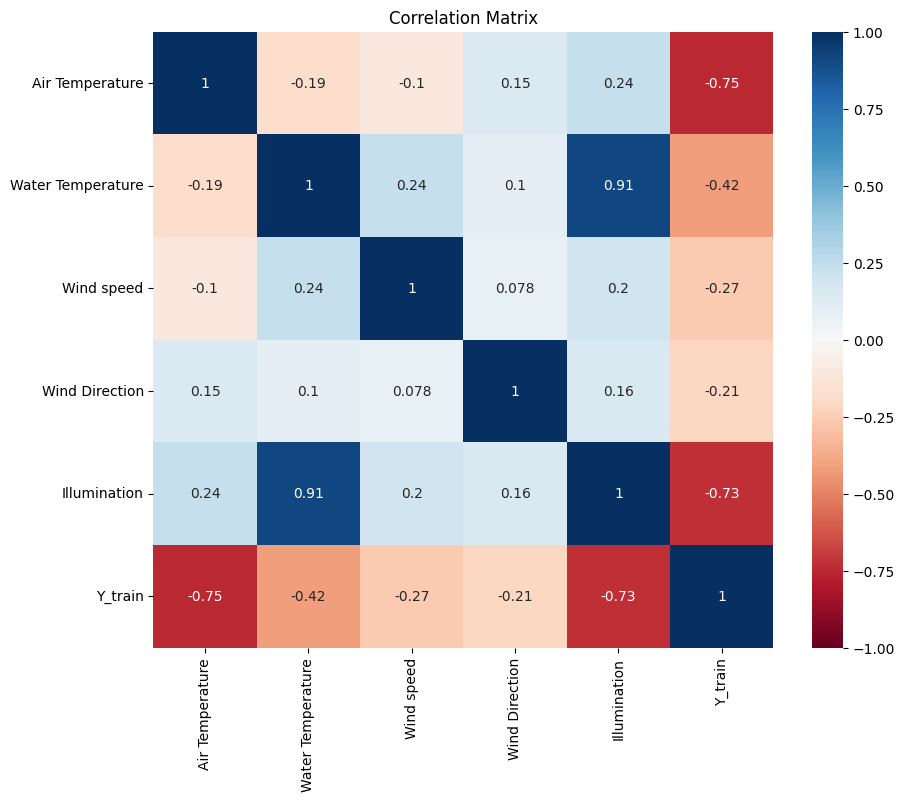

In [267]:
# Removing outliers from the training data using multivariate anomaly detection.

def remove_outliers(data, outliers):
    cleaned_data = data[~data['Y_train'].isin(outliers).reset_index(drop=True)]
    return cleaned_data

cleaned_data = remove_outliers(train_data, outliers)
correlation_matrix = cleaned_data.corr()
plt.figure(figsize=(10, 8))  # Set the figure size
sns.heatmap(correlation_matrix, annot=True, cmap='RdBu', vmin=-1, vmax=1, center=0)
plt.title('Correlation Matrix')
plt.show()

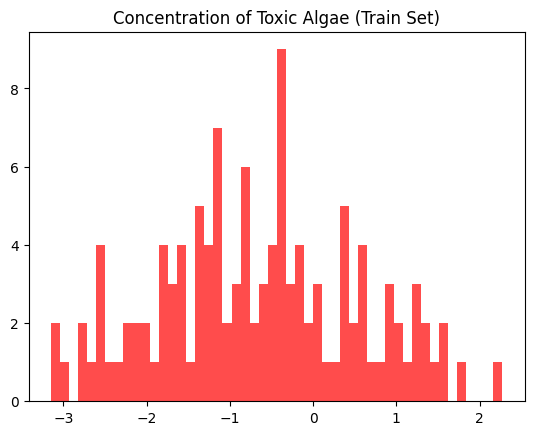

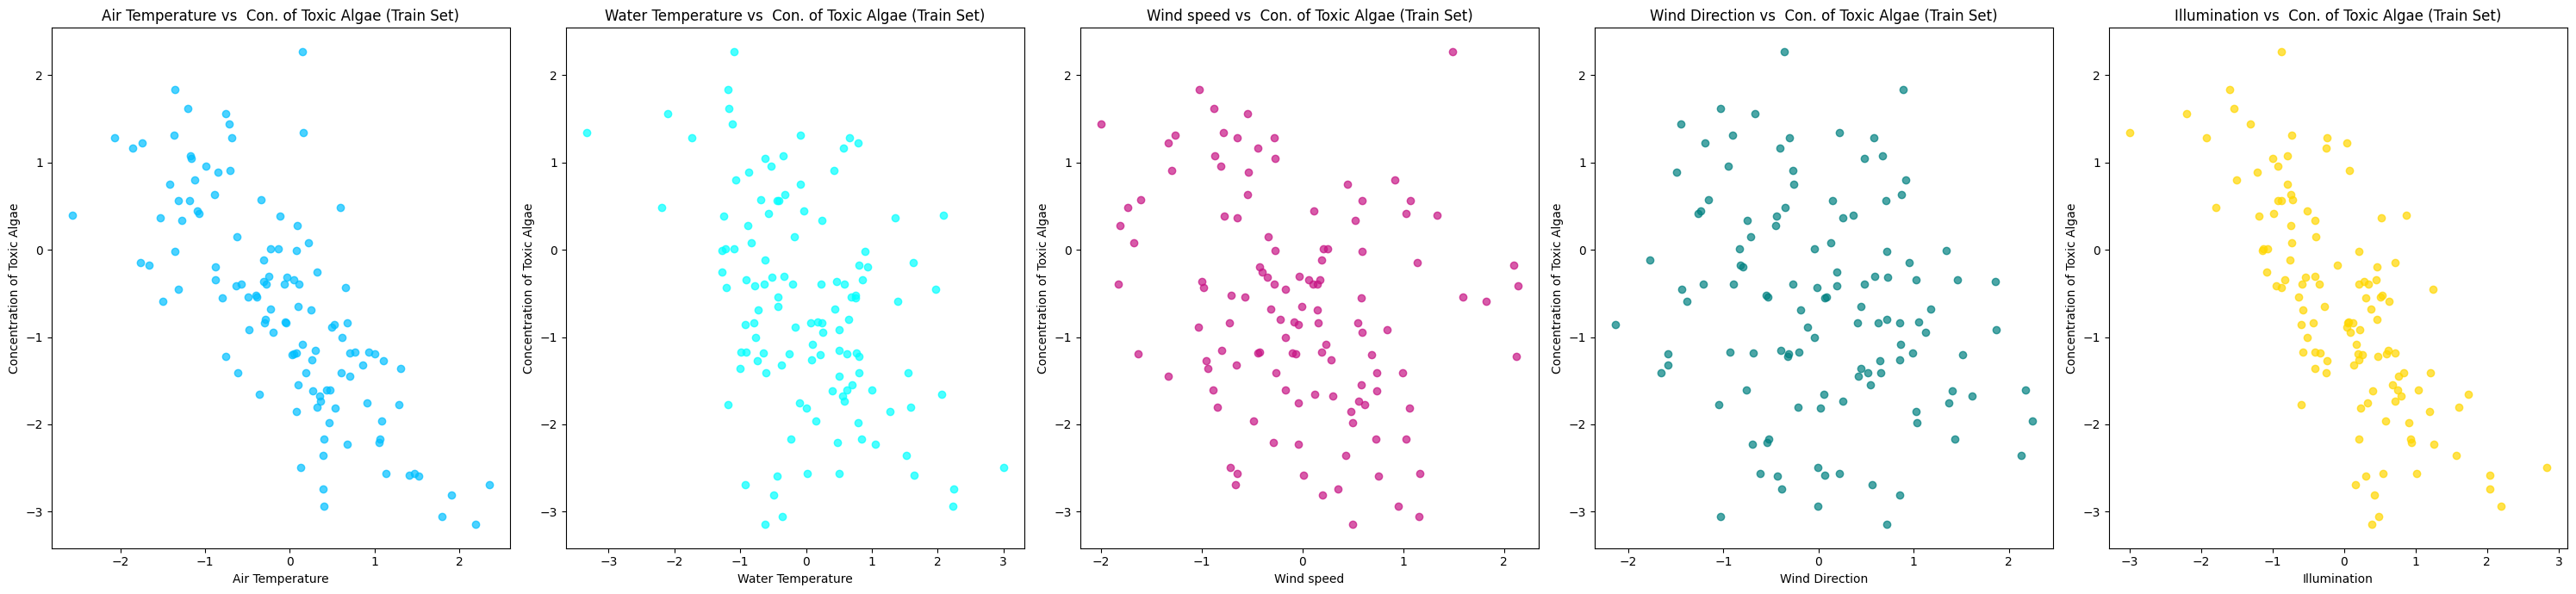

In [268]:
plt.hist(cleaned_data['Y_train'], bins=50, color='red', alpha=0.7)
plt.title('Concentration of Toxic Algae (Train Set)')
plt.show()

fig, axes = plt.subplots(1, 5, figsize=(30, 7))

for i, feature in enumerate(train_features):
    axes[i].scatter(cleaned_data[feature], cleaned_data['Y_train'], alpha=0.7, color = colours[i])
    axes[i].set_title(f'{feature} vs  Con. of Toxic Algae (Train Set)')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Concentration of Toxic Algae')

plt.tight_layout() 
plt.show()

MSE of OLS: 23.57459564309746


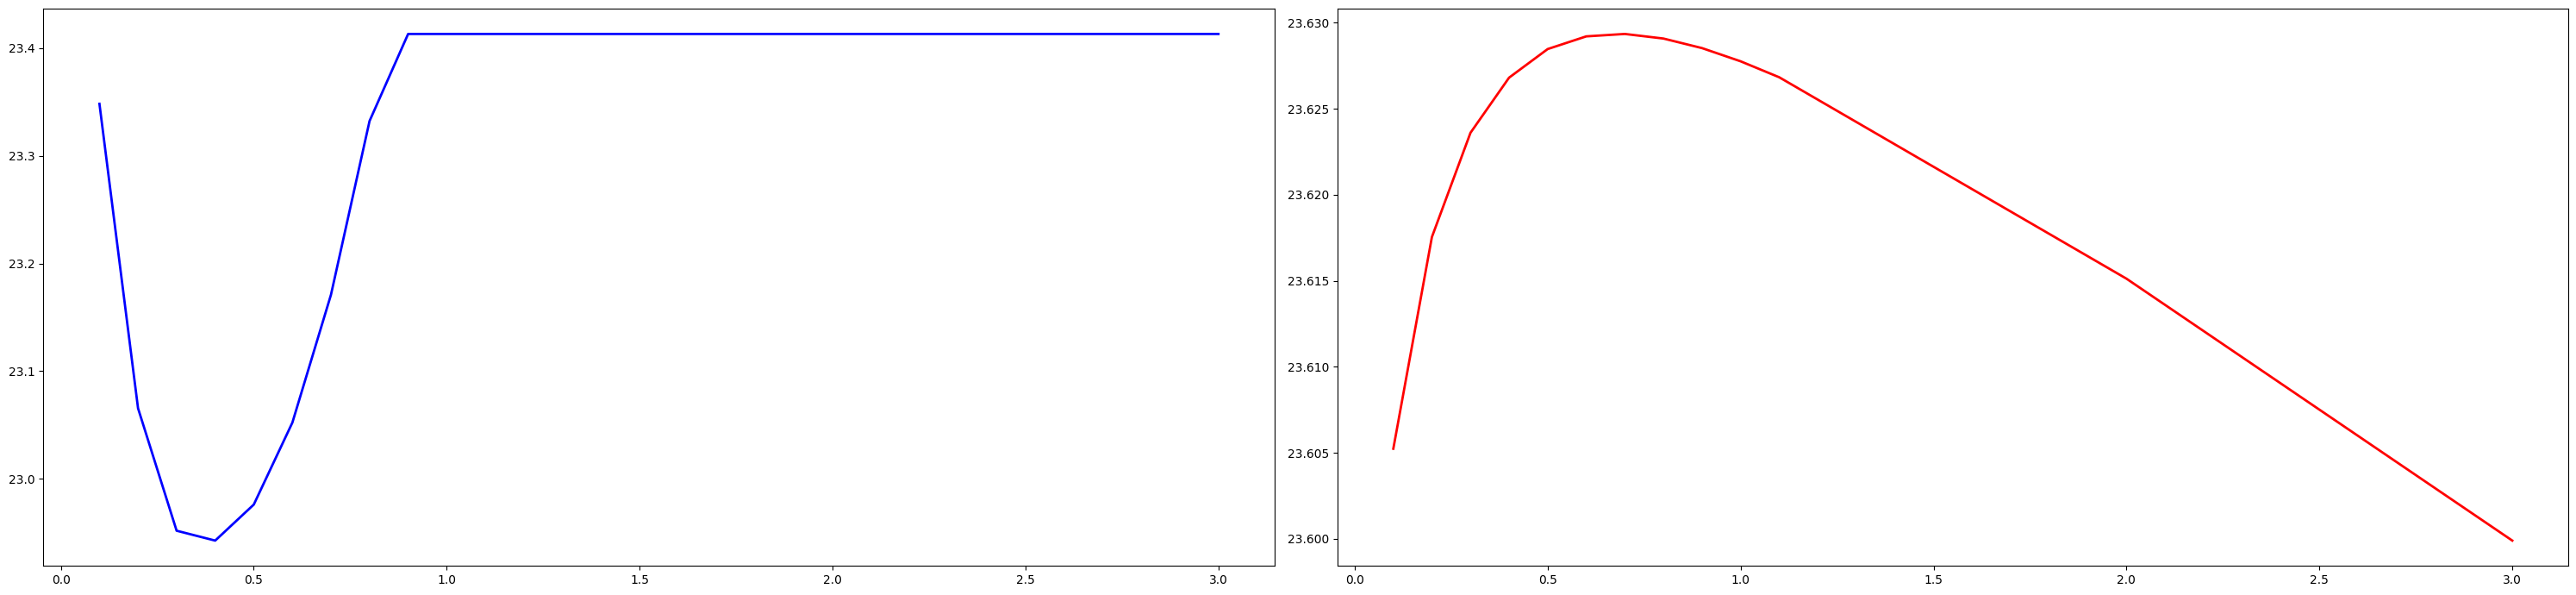

    Alpha  L1_Ratio        MSE
38    0.4       0.9  22.942213
39    0.4       1.0  22.942791
37    0.4       0.8  22.943681
45    0.5       0.6  22.945815
44    0.5       0.5  22.946637


In [269]:
lr = LinearRegression()

lr.fit(cleaned_data[train_features], cleaned_data['Y_train'])
y_pred_OLS = lr.predict(X_val_df)
print(f"MSE of OLS: {mean_squared_error(Y_val, y_pred_OLS)}")

alpha = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1,1.1,2,3]

ratios = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
lasso_mse_array = []
ridge_mse_array = []

for i in range(0,len(alpha)):
    lasso = Lasso(alpha=alpha[i])
    lasso.fit(cleaned_data[train_features], cleaned_data['Y_train'])
    y_pred_lasso = lasso.predict(X_val_df)
    lasso_mse = mean_squared_error(Y_val, y_pred_lasso)
    lasso_mse_array.append([alpha[i], lasso_mse])
    ridge = Ridge(alpha=alpha[i])
    ridge.fit(cleaned_data[train_features], cleaned_data['Y_train'])
    y_pred_ridge = ridge.predict(X_val_df)
    ridge_mse = mean_squared_error(Y_val, y_pred_ridge)
    ridge_mse_array.append([alpha[i], ridge_mse])

lasso_mse_array = np.array(lasso_mse_array)
ridge_mse_array = np.array(ridge_mse_array)
en_mse_array = []
for i in alpha:
    for j in ratios:
        en = ElasticNet(alpha=i, l1_ratio=j)
        en.fit(cleaned_data[train_features], cleaned_data['Y_train'])
        y_pred_en = en.predict(X_val_df)
        en_mse = mean_squared_error(Y_val, y_pred_en)
        en_mse_array.append([i, j, en_mse])

en_mse_array = np.array(en_mse_array)
fig, axes = plt.subplots(1, 2, figsize=(30, 7))
axes[0].plot(lasso_mse_array[:,0], lasso_mse_array[:,1], color='blue', linewidth=2, label='Lasso')
axes[1].plot(ridge_mse_array[:,0], ridge_mse_array[:,1], color='red', linewidth=2, label='Ridge')
plt.tight_layout() 
plt.show()
L1_ratio_results = pd.DataFrame(en_mse_array, columns=['Alpha', 'L1_Ratio', 'MSE']).sort_values(by='MSE')
print(L1_ratio_results.head())

RANSAC Outlier detection

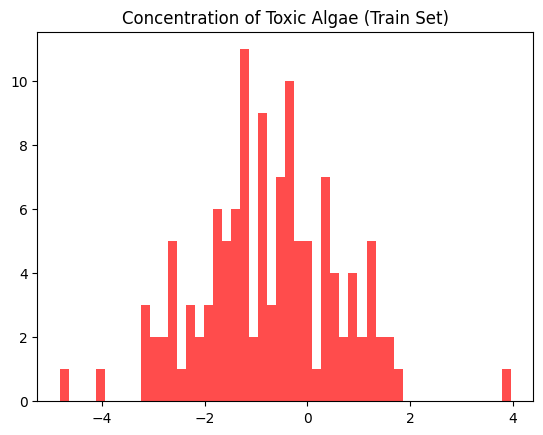

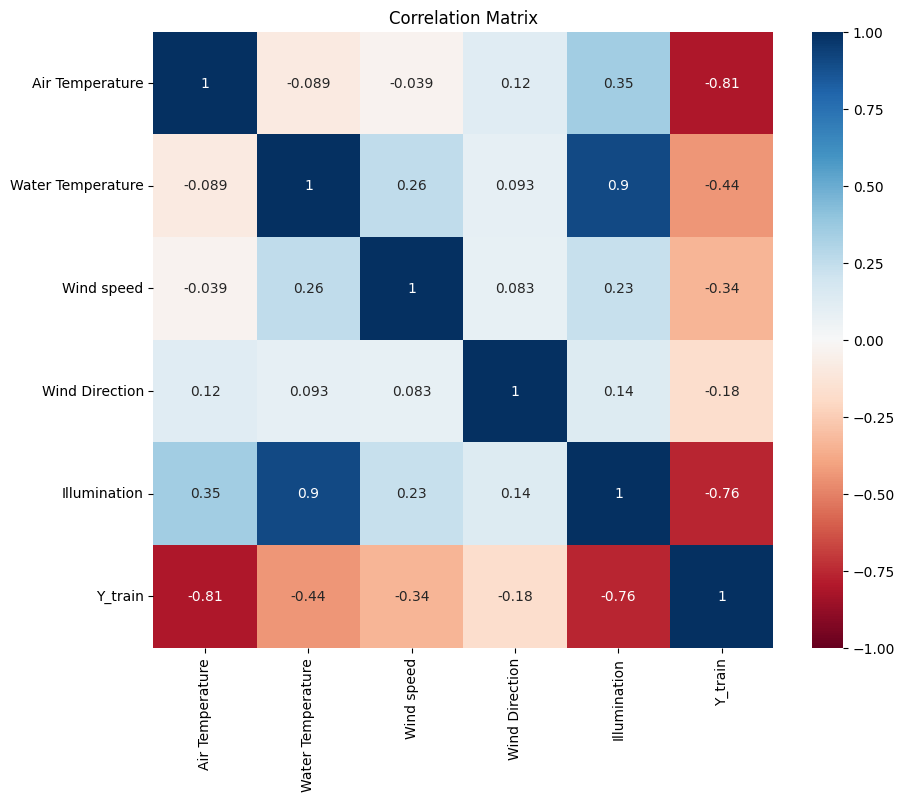

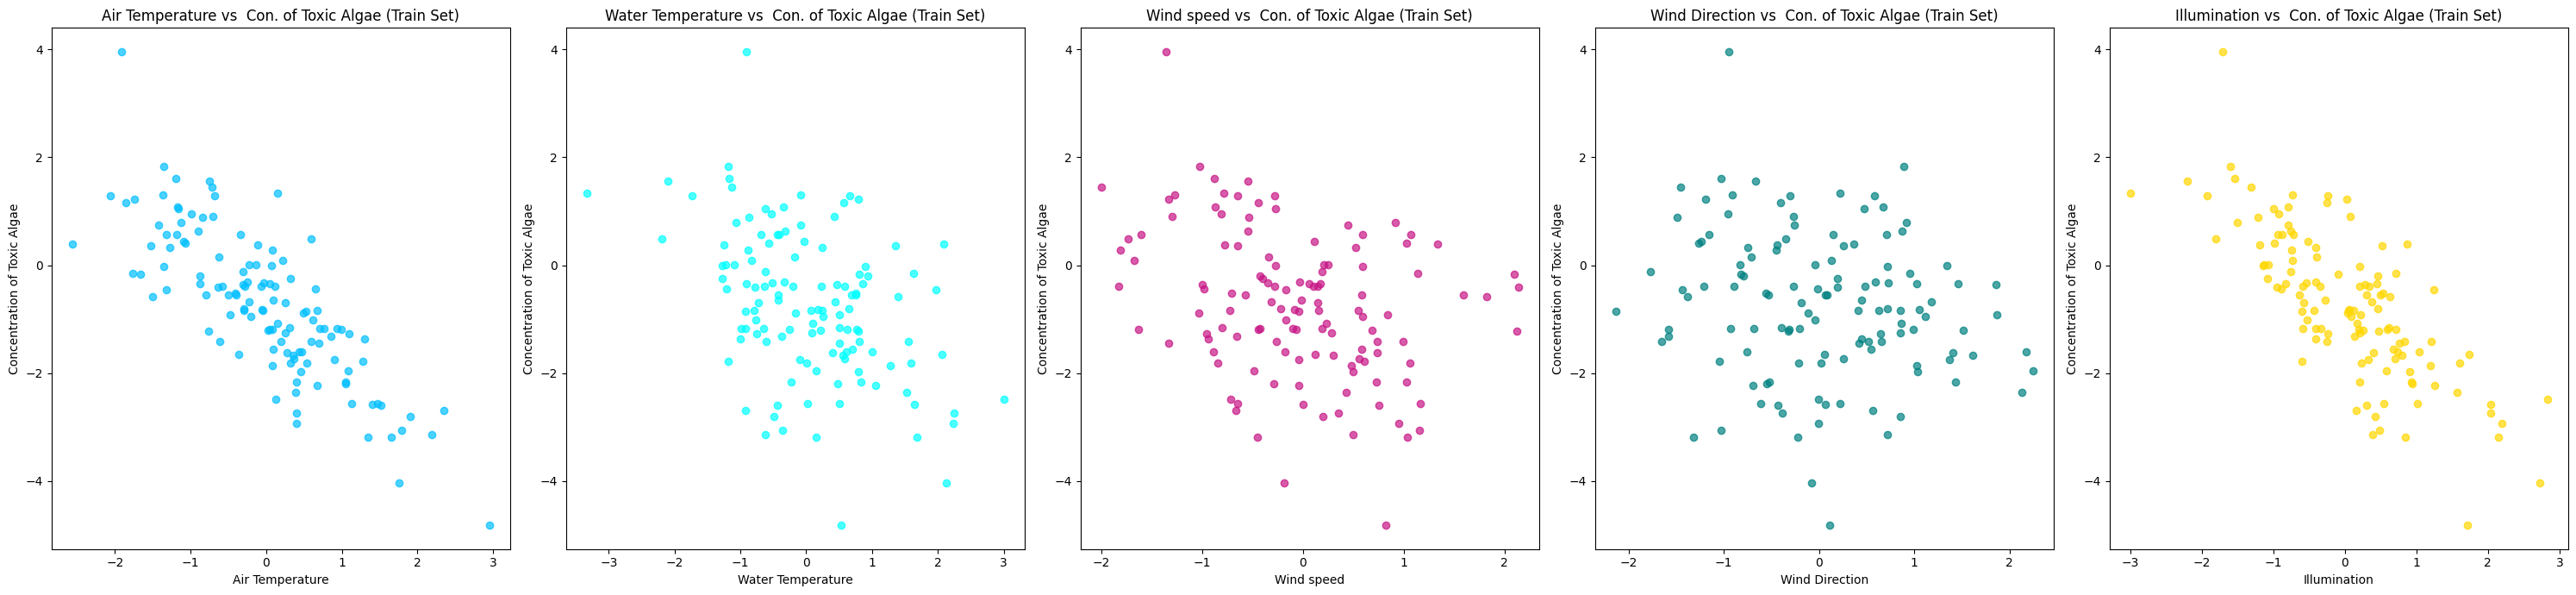

In [270]:
ransac = RANSACRegressor(
    estimator=LinearRegression(), 
    stop_n_inliers= 150, 
    random_state=42
)

ransac.fit(X_train_norm, Y_train)

inlier_mask = ransac.inlier_mask_

train_data_inliers = train_data[inlier_mask]
train_data_inliers = train_data_inliers.reset_index(drop=True)

plt.hist(train_data_inliers['Y_train'], bins=50, color='red', alpha=0.7)
plt.title('Concentration of Toxic Algae (Train Set)')
plt.show()

correlation_matrix = train_data_inliers.corr()
plt.figure(figsize=(10, 8))  # Set the figure size
sns.heatmap(correlation_matrix, annot=True, cmap='RdBu', vmin=-1, vmax=1, center=0)
plt.title('Correlation Matrix')
plt.show()
fig, axes = plt.subplots(1, 5, figsize=(30, 7))

for i, feature in enumerate(train_features):
    axes[i].scatter(train_data_inliers[feature], train_data_inliers['Y_train'], alpha=0.7, color = colours[i])
    axes[i].set_title(f'{feature} vs  Con. of Toxic Algae (Train Set)')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Concentration of Toxic Algae')

plt.tight_layout() 
plt.show()

MSE of OLS: 23.897328287426


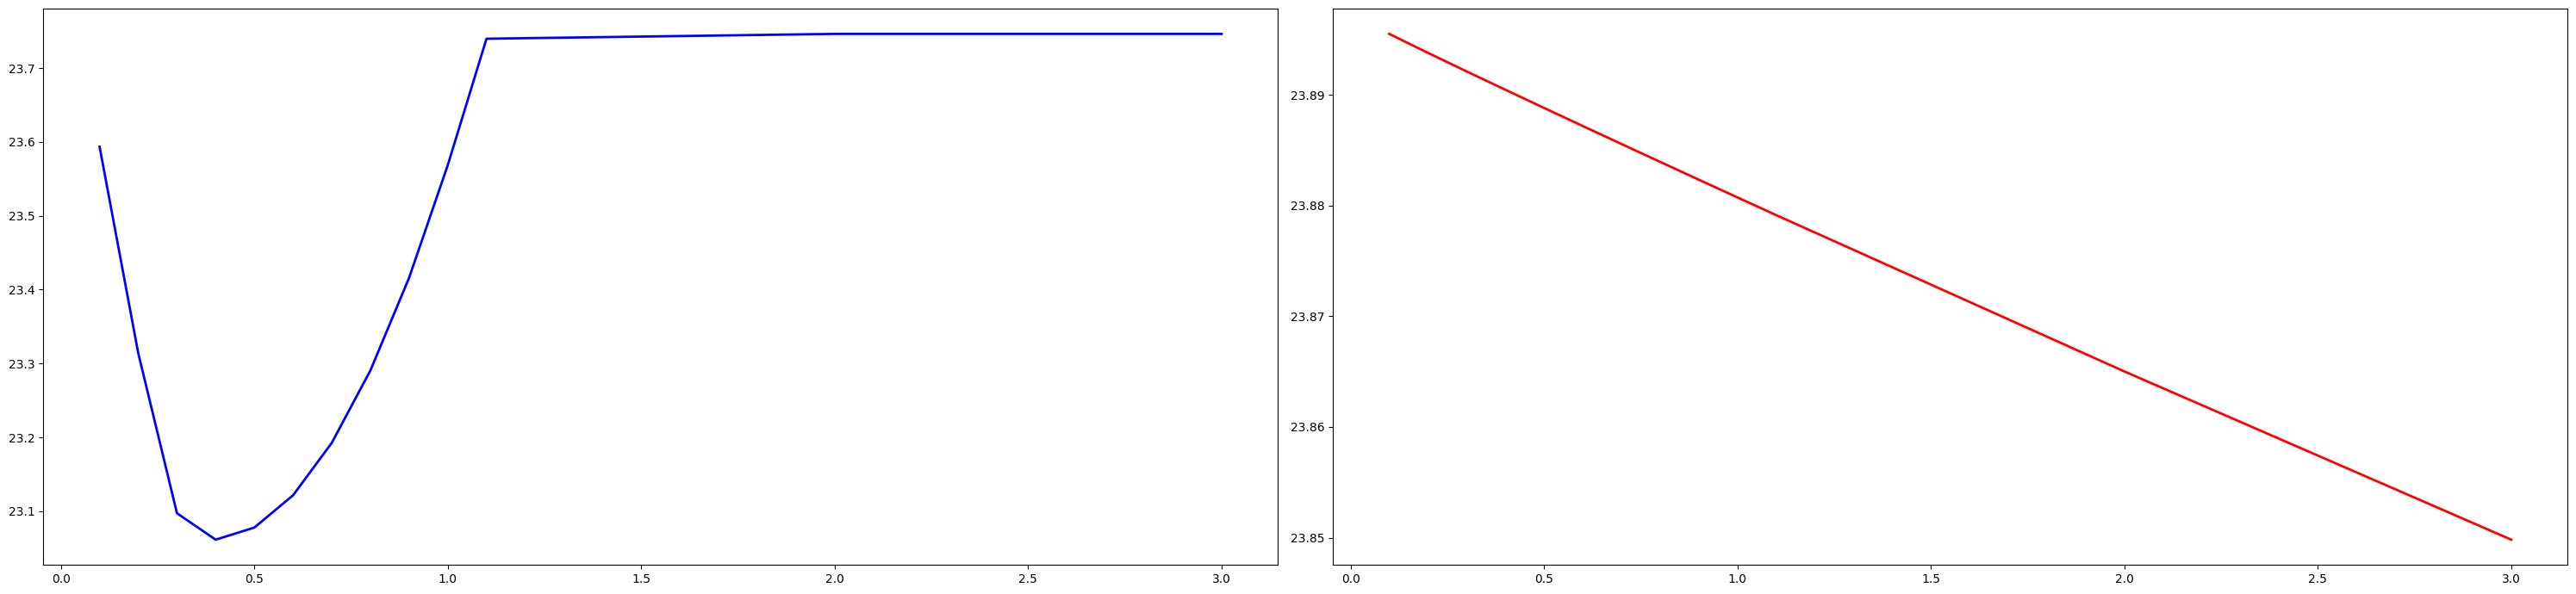

    Alpha  L1_Ratio        MSE
39    0.4       1.0  23.061397
38    0.4       0.9  23.064252
37    0.4       0.8  23.068033
46    0.5       0.7  23.072118
47    0.5       0.8  23.072299


In [271]:
lr = LinearRegression()

lr.fit(train_data_inliers[train_features], train_data_inliers['Y_train'])
y_pred_OLS = lr.predict(X_val_df)
print(f"MSE of OLS: {mean_squared_error(Y_val, y_pred_OLS)}")

alpha = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1,1.1,2,3]

ratios = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
lasso_mse_array = []
ridge_mse_array = []

for i in range(0,len(alpha)):
    lasso = Lasso(alpha=alpha[i])
    lasso.fit(train_data_inliers[train_features], train_data_inliers['Y_train'])
    y_pred_lasso = lasso.predict(X_val_df)
    lasso_mse = mean_squared_error(Y_val, y_pred_lasso)
    lasso_mse_array.append([alpha[i], lasso_mse])
    ridge = Ridge(alpha=alpha[i])
    ridge.fit(train_data_inliers[train_features], train_data_inliers['Y_train'])
    y_pred_ridge = ridge.predict(X_val_df)
    ridge_mse = mean_squared_error(Y_val, y_pred_ridge)
    ridge_mse_array.append([alpha[i], ridge_mse])

lasso_mse_array = np.array(lasso_mse_array)
ridge_mse_array = np.array(ridge_mse_array)
en_mse_array = []
for i in alpha:
    for j in ratios:
        en = ElasticNet(alpha=i, l1_ratio=j)
        en.fit(train_data_inliers[train_features], train_data_inliers['Y_train'])
        y_pred_en = en.predict(X_val_df)
        en_mse = mean_squared_error(Y_val, y_pred_en)
        en_mse_array.append([i, j, en_mse])

en_mse_array = np.array(en_mse_array)
fig, axes = plt.subplots(1, 2, figsize=(30, 7))
axes[0].plot(lasso_mse_array[:,0], lasso_mse_array[:,1], color='blue', linewidth=2, label='Lasso')
axes[1].plot(ridge_mse_array[:,0], ridge_mse_array[:,1], color='red', linewidth=2, label='Ridge')
plt.tight_layout() 
plt.show()
L1_ratio_results = pd.DataFrame(en_mse_array, columns=['Alpha', 'L1_Ratio', 'MSE']).sort_values(by='MSE')
print(L1_ratio_results.head())

In [272]:
grid_search = GridSearchCV(en, param_grid, cv=5, scoring='neg_mean_squared_error')
y__cv = grid_search.fit(train_data_inliers[train_features], train_data_inliers['Y_train'])
        
best_params = grid_search.best_params_
        


print(f"Best Parameters: {best_params}")

Best Parameters: {'alpha': 0.1, 'l1_ratio': 0.1}
